## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import r2_score, f1_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

## Start functions

In [2]:
data = pd.read_csv("data\matchs_2013_2022.csv", sep=",")
dataAPredire = pd.read_csv("data\match_2023.csv", sep=",")
y = data["results"]

def remove_categorical():
    X = data[dataAPredire.columns].drop("date", axis=1)
    
    categoricalData = X.select_dtypes(include=['object'])
    # categoricalData = categoricalData.drop(columns=["date","home_club_name","away_club_name","home_club_manager_name","away_club_manager_name","referee", "stadium"])
    # print(f'shape of categorical data: {categoricalData.shape}'),

    dataToOHE = pd.DataFrame([])
    ohe = OneHotEncoder()
    X[dataToOHE.columns] = dataToOHE.apply(ohe.fit_transform)

    dataToLabelEncode = categoricalData
    le = LabelEncoder()
    X[dataToLabelEncode.columns] = dataToLabelEncode.apply(le.fit_transform)

    return X

def plot_correlation_matrix(data):
    correlation_matrix = data.corr()
    plt.figure(figsize=(20, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.show()

def create_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestClassifier()
    
    max_missing = 0.1 * len(X_train)
    missing_values = X.isna().sum()

    if all(missing_values < max_missing):
        imputer = SimpleImputer(strategy='mean')
    else:
        imputer = SimpleImputer(strategy='constant', fill_value=0)

    pipeline = Pipeline([
        ('imputer', imputer),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    return model    

def get_accuracy_with_model(model, X_train, X_test, y_train, y_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

def test_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = create_model(X, y)
    return get_accuracy_with_model(model, X_train, X_test, y_train, y_test)


## Process the data

In [3]:
X = remove_categorical()

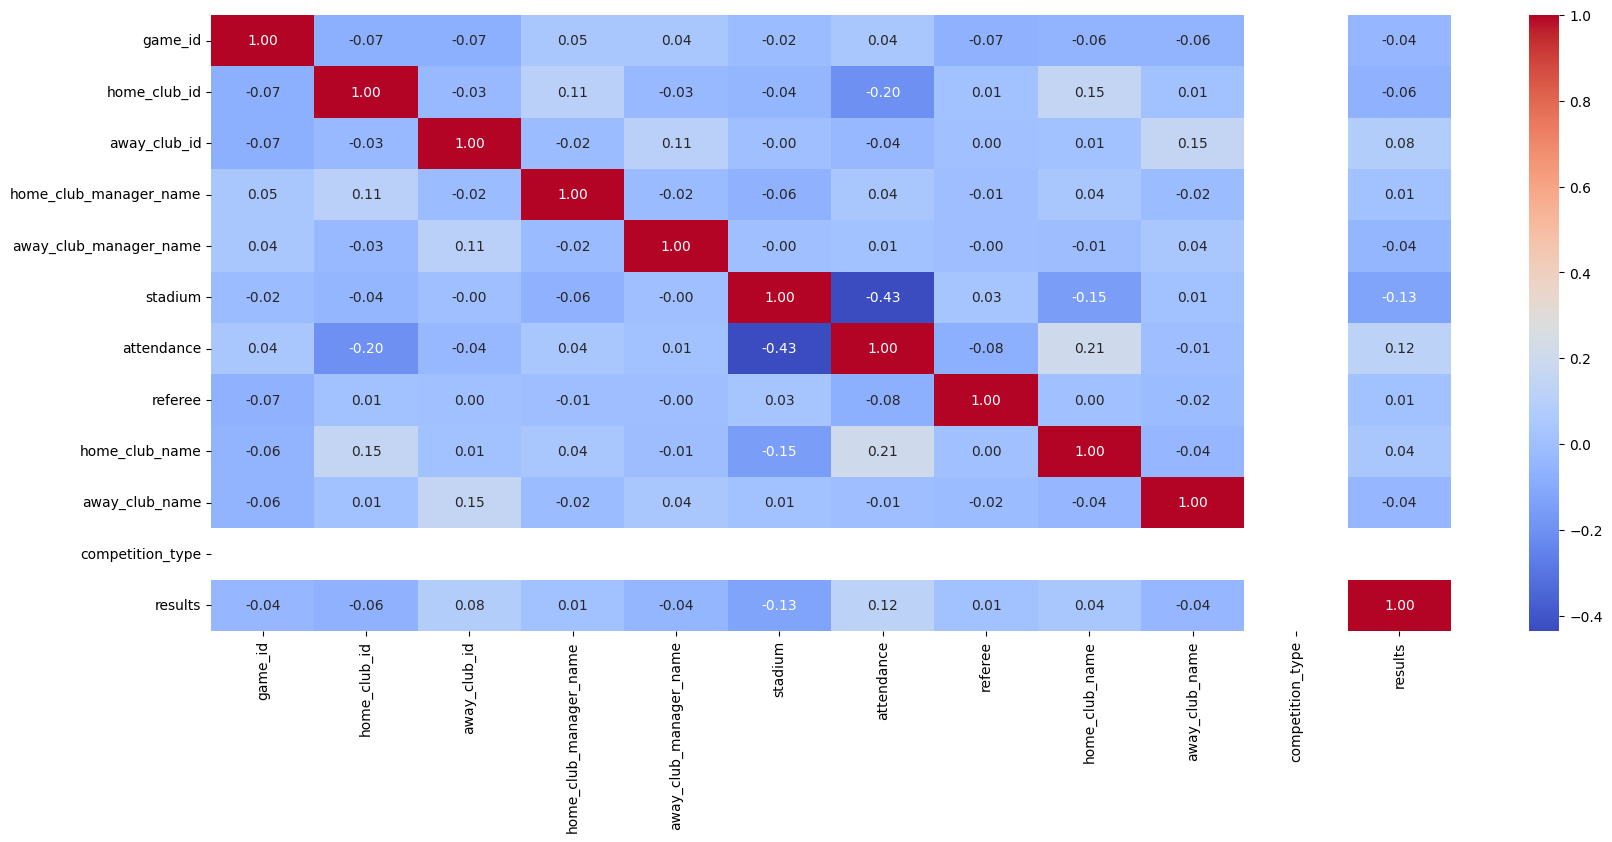

In [4]:
matCorr = pd.DataFrame(X)
matCorr['results'] = y
plot_correlation_matrix(matCorr)

## Create Model

In [5]:
model = create_model(X, y)

print(f'Number of rows before imputing missing values: {len(X)}')
print(f'Number of columns before imputing missing values: {X.shape[1]}')


Number of rows before imputing missing values: 4078
Number of columns before imputing missing values: 11


## Predict 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
accuracy = get_accuracy_with_model(model, X_train, X_test, y_train, y_test)

print(f'accuracy score: {accuracy}')

accuracy score: 0.4742647058823529


## Adding more columns to the data

In [7]:
def convert_string_to_thousands(s):
    # Remove the € sign
    s = s.replace('€', '')
    # get the sign of the value
    sign = 1 if s[0] != '-' else -1
    s = s.replace('-', '').replace('+', '')
    # print(s)
    value = float(s[:-1] if len(s) > 1 else 0)
    multiplier = {'k': 1, 'm': 1000}.get(s[-1:], 1)
    # Return the numeric value multiplied by the multiplier
    return value * multiplier * sign

In [23]:
# Adding a score for each team
dataTeams = pd.read_csv("data\clubs_fr.csv", sep=",")
dataTeams["transfer_num"] = dataTeams["net_transfer_record"].apply(convert_string_to_thousands)
dataTeams["transfer_num"]

X = data[dataAPredire.columns]

X = X.merge(dataTeams[['club_id', 'transfer_num']],
                                  left_on='home_club_id',
                                  right_on='club_id',
                                  how='left').rename(columns={'transfer_num': 'transfer_home_team'})
X = X.merge(dataTeams[['club_id', 'transfer_num']],
                                  left_on='away_club_id',
                                  right_on='club_id',
                                  how='left').rename(columns={'transfer_num': 'transfer_away_team'})


## Add a average score for each player

In [18]:
playerValuation = None
playerAppearances = None
def get_name_player(id):
    global playerAppearances
    playerAppearances = pd.read_csv("data\player_appearance.csv", sep=",") if playerAppearances is None else playerAppearances
    player = playerAppearances[playerAppearances["player_id"] == id]["player_name"]
    return player[0]
def concatLits(liste):
    return list(set([item for sublist in liste for item in sublist]))
def get_score_player(id):
    global playerValuation
    playerValuation = pd.read_csv("data\player_valuation_before_season.csv", sep=",") if playerValuation is None else playerValuation
    player = playerValuation[playerValuation["player_id"] == id]["market_value_in_eur"].apply(lambda x: x/1e6)
    return player.mean() if len(player) > 0 else 0


In [20]:
teamComps = None
def get_score_team(team):
    global teamComps
    if(teamComps is None):
        lineups = pd.read_csv("data\game_lineups.csv", sep=",")
        teamComps = lineups.groupby(['club_id'])['player_id'].apply(list).reset_index()
        # print(teamComps)
        teamComps = teamComps.groupby(['club_id'])['player_id'].apply(list).apply(concatLits).reset_index()
        teamComps["score"] = teamComps["player_id"].apply(lambda x: sum([get_score_player(i) for i in x]))
        
    return teamComps[teamComps["club_id"] == team]["score"].values[0]

X["score_away_team"] = X["away_club_id"].apply(get_score_team)
X["score_home_team"] = X["home_club_id"].apply(get_score_team)

C:\Users\lorra\AppData\Local\Temp\ipykernel_7604\966980543.py:5: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  lineups = pd.read_csv("data\game_lineups.csv", sep=",")


In [21]:
test_data(X, y)


0.4730392156862745